![image.png](plots/portada_mnist_2.png)

# Introducción
___

En esta sesión resolveremos un problema real de reconocimiento de imágenes utilizando el conjunto de datos MNIST. También hablaremos de conceptos comno la división en train / test, la validación cruzada, y de distintas métricas para evaluar nuestros clasificadores, dependiendo del objetivo que busquemos conseguir con nuestro algoritmo. Por último, estudiaremos las opciones más utilizadas para optimizar los hiperparámetros de nuestras SVM.

# Dataset MNIST
___

El conjunto de datos de MNIST recoge muestras de __números escritos a mano__ por 70000 estudiantes de institutos en EEUU. Todas las __imagenes son en blanco y negro y tienen tamaño 28 pixels x 28 pixels__. Además incluyen una etiqueta con el dígito al que corresponden. Empecemos por descargar el conjunto de datos, disponible en [la web de openml](https://www.openml.org/search?type=data).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

np.random.seed(5) # Los resultados del notebook serán los mismos en cada ejecución

In [2]:
mnist = fetch_openml('mnist_784', version=1)

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

y = y.astype(np.uint8)  # Convertir y a números enteros.

print(f'Dimensiones X: {X.shape}\nDimensiones y: shape{y.shape}')

Dimensiones X: (70000, 784)
Dimensiones y: shape(70000,)


Podemos representar algunos de los datos utilizando la función `imshow`, que recibe una matriz con la intensidad de los píxeles:

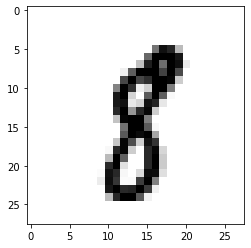

In [5]:
digit_image = X[300,:].reshape((28,28))
plt.imshow(digit_image, cmap='binary')

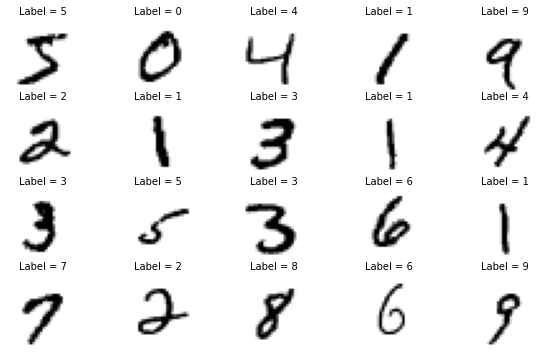

In [4]:
plt.figure(figsize=(10,6))

for i in range(20):
    plt.subplot(4, 5, i+1)
    digit_image = X[i,:].reshape((28, 28))
    plt.imshow(digit_image, cmap='binary')
    plt.title(f'Label = {y[i]}', fontsize=10)
    plt.axis('off')

# Train / test split
___

![image.png](plots/meme_train_test.png)

El primer paso cuando nos planteamos analizar un conjunto de datos, siempre debe ser el de __dividirlo en train y test__, y dejar la parte de test a un lado. Sin mirarla, sin tocarla. De esta forma, cuando comprobemos la calidad de nuestro modelo usando el test set, podremos garantizar que ni nosotros, ni el modelo, tenía ningún tipo de información previa acerca del test set, lo que permite reducir el overfitting.

Para dividir el conjunto de datos, simplemente __tomamos aproximadamente un 20\% del conjunto al azar__ como test, y el resto como train. Aunque hay un factor extra a tener en cuenta en problemas de clasificación, y es que __la proporción de datos que tengamos de cada categoría debe mantenerse__. Si tenemos un problema de clasificación binario en el que una categoría representa el 30\% y la otra el 70\%, es importante que esta proporción se mantenga en el train y el test set. Es lo que se conoce como __stratified sampling__.

Para hacer esta división usaremos la función de `train_test_split` de sklearn.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Veamos si cada categoría sigue manteniendo la proporción de imagenes asociadas a cada dígito:

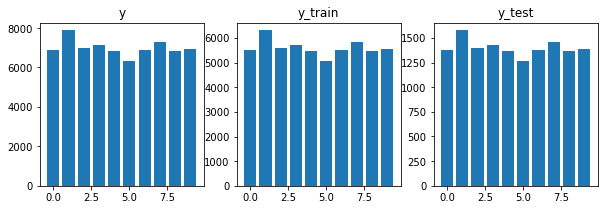

In [7]:
plt.figure(figsize=(10, 3))

list_y = [y, y_train, y_test]
titles = ['y', 'y_train', 'y_test']

for idx, y_tmp in enumerate(list_y):
    unique, counts = np.unique(y_tmp, return_counts=True)
    plt.subplot(1, 3, idx+1)
    plt.bar(unique, counts)
    plt.title(titles[idx])


__Cuando se trabaja con conjuntos de datos grandes, es muy habitual tomar una muestra del conjunto de train__ y trabajar con esa muestra reducida primero. De esta forma se pueden construir distintos modelos de forma rápida, ver cuales funcionan mejor, y llevar las mejores alternativas al conjunto de datos final. En nuestro caso, para agilizar la ejecución de los modelos, tomaremos un subconjunto de 2000 imágenes del conjunto de train, que será el que utilizaremos para entrenar los modelos.

### <font color='D12828'> Ejercicio: </font>
Divide los conjuntos `X_train` e `y_train` en dos subconjuntos cada uno, `X_train1`, `X_train2`, `y_train1` e `y_train2` utilizando la función de sklearn, de tal forma que `X_train1` tenga 2000 observaciones. Pista: los parámetros `train_size` y `test_size` pueden recibir como input un porcentaje, o un tamaño muestral.

In [8]:
# Ejercicio
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, train_size=2000, random_state=42, stratify=y_train)

In [9]:
X_train1.shape

(2000, 784)

## Estandarización de los datos

A continuación estandarizamos los datos. Dado que cualquer transformación que apliquemos al conjunto de datos (entre las que se incluye la estandarización) forma parte del proceso de construcción del modelo, estas transformaciones siempre deben hacerse en términos del conjunto de training. Esto implica que a la hora de estandarizar el conjunto de test, deben usarse los valores de media y desviación típica del training set. La función `StandardScaler` de Python gestiona esto de forma automática.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train1_s = scaler.fit_transform(X_train1)

# Clasificador binario
___

Empecemos trabajando con una versión simplificada de este problema. En vez de clasificar todos los números, construiremos un clasificador que distinga si el número en cuestión es un 5 o no es un 5. Es lo que se conoce como un problema binario.

### <font color='D12828'> Ejercicio: </font>
* Crear un vector llamado `y_train_5` de longitud 2000, que tenga valor 1 en aquellas posiciones en las que `y_train1` tenga un 5, y 0 en el resto.
* Crear un vector llamado `y_test_5`, que tenga valor 1 en aquellas posiciones en las que `y_test` tenga un 5, y 0 en el resto.

In [12]:
# Ejercicio
y_train_5 = (y_train1 == 5).astype(int)
y_test_5 = (y_test == 5).astype(int)

print(y_train_5[0:10])

[0 0 0 0 0 0 0 0 0 0]


# Cross-validation
___

Una vez tenemos definido nuestro conjunto de entrenamiento podemos empezar a probar algunos modelos. Para ver la calidad de las predicciones, __no queremos usar la parte de test hasta el final__ (así reducimos el overfitting), por lo que necesitamos datos que no sean parte del test set, y en los que no hayamos entrenado los modelos. La alternativa más utilizada para esto es la validación cruzada, en la que dividimos el conjunto de entrenamiento en $k$ bloques, entrenamos al modelo con $(k-1)$ de esos bloques, y lo testeamos con el último bloque. Iteramos $k$ veces cambiando cada vez el conjunto que usamos como test, por lo que conseguimos $k$ medidas de la calidad del modelo.

![image.png](plots/cross_validation.png)



El proceso de validación cruzada está implementado en sklearn en las funciones `cross_val_score` y `cross_val_predict`. Veamos qué tal funcionaría una SVM lineal. Aunque los números de folds más habituales son 5 o 10, utilizaremos 3-fold cross validation para reducir el tiempo computacional. Además, un parámetro muy intereante de estas funciones es el de `n_jobs`, que permite indicar cuantos cores del procesador del ordenador queremos utilizar para __paralelizar el proceso de validación cruzada__. Dado que durante la validación cruzada dividimos el dataset en folds, y el entrenamiento de cada modelo en cada iteración es independiente de las demás, estas se pueden realizar en paralelo, reduciendo en gran medida el tiempo computacional. Por último, en la sesión anterior vimos cómo usar la función `SVC` con kernel `linear`. Para problemas lineales, la implementación de `LinearSVC` es normalmente más rápida, pero debemos incluir el parámetro `loss="hinge"`.

In [14]:
# Detectar numero de cores
import os

num_cores = os.cpu_count()


12

In [15]:
# Definimos una SVM lineal

from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

svc_lineal = LinearSVC(C=1, loss="hinge")

cross_val_score(svc_lineal, X_train1_s, y_train_5, cv=3, scoring="accuracy", n_jobs=num_cores-1)

array([0.91754123, 0.92653673, 0.90690691])

¡Hemos conseguido más de un 90% en todos los bloques! Son unos resultados buenísimos para nuestro primer intento... ¿O no?

# Confusion matrix
___

¿Qué ocurriría si yo no usase ningún algoritmo de machine learning para hacer las predicciones sino que simplemente... __Predijese que no hay ningún 5__ en el conjunto de datos?

In [16]:
accuracy_ningun_5 = (y_train_5 == 0).sum() / len(y_train_5)
print(f'Accuracy prediciendo ningún cinco: {accuracy_ningun_5}')

Accuracy prediciendo ningún cinco: 0.91


Vaya, parece que __no hacer ninguna predicción tiene una precisión del 91%__. Esto se debe a que aproximadamente un 10% de nuestros datos son 5, así que simplemente predecir que no hay 5 nos da un 90% de aciertos. Visto lo visto, busquemos más información, y no solo la tasa de aciertos: calculemos la matriz de confusión de nuestras predicciones.

In [19]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(svc_lineal, X_train1_s, y_train_5, cv=3, n_jobs = num_cores - 1)

confusion_matrix(y_train_5, y_train_pred)

array([[1701,  119],
       [  47,  133]], dtype=int64)

array([1, 0, 0, ..., 0, 0, 0])

Cada fila de la matriz anterior representa la respuesta verdadera, mientras que las columnas son las predicciones hechas por nuestro algoritmo.

* La primera fila considera las imagenes que no eran cincos. De entre estos, 1701 fueron clasificados correctamente como no-cincos (llamados verdaderos negativos), y 119 incorrectamente como cincos (falsos positivos).

* La segunda fila considera las imagenes que eran cincos. De entre estos, 47 fueron clasificados incorrectamente como no-cincos (falsos negativos), y 133 fueron clasificados correctamente como cincos (verdaderos positivos)

* Un clasificador perfecto tendría elementos solo en la diagonal

![image.png](plots/confusion_matrix.png)

Fuente: libro _Hands-on machine learning_

### <font color='D12828'> Ejercicio: </font>
1. Entrena una SVM con un kernel polinómico de grado 3 y coste 1. Llama al vector de predicciones `y_train_pred_poly`
2. Obtén los valores de la matriz de confusión de tu SVM. 

In [20]:
# Ejercicio
from sklearn.svm import SVC

svc_poly = SVC(kernel='poly', degree=3, C=1)

y_train_pred_poly = cross_val_predict(svc_poly, X_train1_s, y_train_5, cv=3, n_jobs = num_cores - 1)

confusion_matrix(y_train_5, y_train_pred_poly)

array([[1815,    5],
       [ 148,   32]], dtype=int64)

## Precision y recall

* __Recall:__ Estudiemos el porcentaje de imagenes que eran cincos que clasificamos correctamente: había 61 + 119 = 180 imágenes de cincos, de los que clasificamos correctamente 119. Eso nos da un recall de 119/180 = 0.66. 

* __Precision__: Estudiemos el porcentaje de imagenes que predijimos que eran cinco y que clasificamos correctamente: predijimos como cinco 71 + 119 = 190 imágenes, de los que verdaderamente eran cincos 119. Eso nos da una precision de 119/190 = 0.62. 

sklearn incorpora las funciones para obtener estos resultados directamente:

In [21]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

print(f'Recall: {recall_score(y_train_5, y_train_pred)}')
print(f'Precision: {precision_score(y_train_5, y_train_pred)}')

Recall: 0.7388888888888889
Precision: 0.5277777777777778


Cuando nuestro algoritmo dice que una imagen es un 5, solo acierta un 52% de las veces (precision). Y además, solo detecta el 73% de los cincos (recall). Tal vez no sea tan bueno como parecía con su 91% de tasa de aciertos... Es por esto que __en un clasificador resulta importante mirar no solo la tasa de aciertos, sino también precision y recall.__ Aunque el mejor clasificador sería el que tuviese los valores más altos posibles en estas tres métricas, __debemos tener en cuenta el objetivo con el que estemos clasificando los datos.__

* Imaginemos que estamos construyendo un clasificador de imágenes para pacientes con cancer de pulmón. Resultaría fundamental que al clasificador no clasificase como sano a ningún paciente con cancer. Es decir, querríamos que la __recall fuese lo más alta posible__. Por otro lado, no sería tan grave si el clasificador predijese que un paciente tiene cancer cuando en realidad no lo tiene. Es decir, no nos importaría tanto la precision.

* De la misma forma, imaginemos que entrenamos un clasificador de videos infantiles. No pasaría nada si algún video bueno fuese clasificado como malo (baja recall) pero sin duda querríamos que todos los videos malos fuesen clasificados como malos (__alta precision__).


### <font color='D12828'> Ejercicio: </font>
1. Obtén los valores de tasa de aciertos, precision y recall de la SVM polinómica entrenada en el ejercicio anterior

In [23]:
# Ejercicio

print(f'Precision: {precision_score(y_train_5, y_train_pred_poly)}')
print(f'Recall: {recall_score(y_train_5, y_train_pred_poly)}')
print(f'Accuracy: {accuracy_score(y_train_5, y_train_pred_poly)}')

Precision: 0.8648648648648649
Recall: 0.17777777777777778
Accuracy: 0.9235


## Trade-off precision / recall
Dado un clasificador como la SVM anterior, existe un __trade-off entre precision y recall__. Recordemos que las predicciones en nuestra SVM se basaban en una función de decisión que es un hiperplano. Si una observación tiene un valor de la función de decisión negativo, corresponde a una categoría, y si es positivo, a la otra. Podemos ver el valor de la función de decisión para cualquier observación con la función `decision_function`:

In [24]:
imagen_al_azar = X_train1[100, :]

svc_lineal.fit(X_train1_s, y_train_5)

svc_lineal.decision_function([imagen_al_azar])

C:\Users\alvaromc317\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


array([-533.18524406])

In [25]:
svc_lineal.predict([imagen_al_azar])

array([0])

Como el valor de la función de decisión es negativo, la predicción es `False`.

Ahora bien, en vez de fijar el valor 0 como frontera para nuestras decisiones, podemos fijar otro valor, lo que afecta a los porcentajes de precision y recall. La siguiente imagen muestra algunos dígitos ordenados de mayor a menor valor de la función de decisión.

![image.png](plots/tradeoff_precision_recall.png)
Fuente: libro _Hands-on machine learning_

* Si fijamos el threshold en 0, tendremos 4 verdaderos positivos, y un falso positivo (un seis). Así que con ese threshold tendríamos 4/5 = 0.8 de precisión. Pero de los 6 cincos, el algoritmo solo clasifica correctamente 4, así que el recall sería 4/6=0.67

* Si aumentamos el threshold, tendríamos 3 verdaderos positivos, y ningún falso positivo (precisión del 100%), pero tendríamos por otro lado que de 6 cincos, clasificamos 3 correctamente (recall=3/6=0.5)

Resumiendo, __elevar el threshold aumenta la precisión pero baja el recall. Bajar el threshold aumenta el recall pero baja la precisión.__ Conviene remarkar que hay situaciones en las que la precision puede bajar cuando elevamos el threshold, aunque lo normal es que suba. Observa en la imagen anterior lo que ocurre si desplazamos el threshold de la posición central un digito hacia la derecha. La precision pasa de 4/5=0.8 a 3/4=0.75.

Podemos representar gráficamente los valores de precision y recall en función del threshold. Para ello, obtenemos los valores de la función de decisión (nuestro hiperplano) usando la función `cross_val_predict` y usamos la función `precision_recall_curve` para obtener los valores de ambas métricas.

In [26]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(svc_lineal, X_train1_s, y_train_5, cv=3, method="decision_function", n_jobs = num_cores - 1)

In [27]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

recall_60_precision = recalls[np.argmax(precisions >= 0.60)]

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    """
    precisions: Vector con valores de la precision de un 
                clasificador para distintos threshodls
    precisions: Vector con valores de la recall de un 
                clasificador para distintos threshodls
    Representación gráfica de precision vs recall
    """
    plt.plot(recalls, precisions, 'b-', linewidth=2)  # Precision vs recall
    plt.xlabel("Recall", fontsize=16)                 # Etiqueta del eje x
    plt.ylabel("Precision", fontsize=16)              # Etiqueta del eje y
    plt.axis([0, 1, 0, 1])                            # Ajustamos ejes
    plt.grid(True)                                    # Añadimos grid

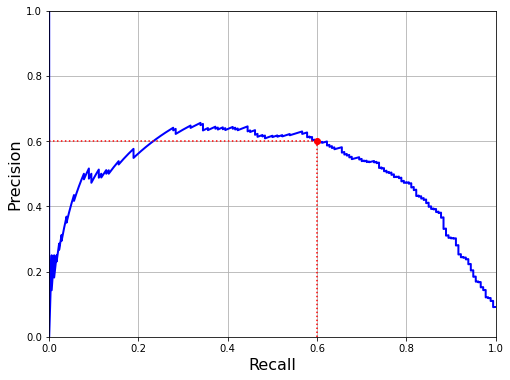

In [29]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

plt.plot([recall_60_precision, recall_60_precision], [0., 0.6], "r:") # Marcar con que valor del recall se tiene una precision del 60%
plt.plot([0.0, recall_60_precision], [0.6, 0.6], "r:")                # Marcar precision 60%
plt.plot([recall_60_precision], [0.6], "ro")                          # Marcar punto

In [30]:
threshold_60_precision = thresholds[np.argmax(precisions >= 0.60)]

print(f'Se obtiene una precisión del 60% con un threshold de {np.round(threshold_60_precision, 3)}')

Se obtiene una precisión del 60% con un threshold de 0.519


Un buen clasificador tendría valores altos de recall y precisión, es decir, estaría cerca de la esquina superior derecha. Como resumen de esta gráfica, puede utilizarse el cálculo del area bajo la curva. Cuanto más cercano a la esquina superior derecha esté el clasificador, más próximo a 1 será el valor de este area.

In [31]:
from sklearn.metrics import auc
auc(recalls, precisions)

0.5083189942974143

### <font color='D12828'> Ejercicio: </font>
1. Obtén la gráfica precision / recall para la SVM polinómica entrenada antes, y el valor del area bajo su curva.

0.7457164408990823

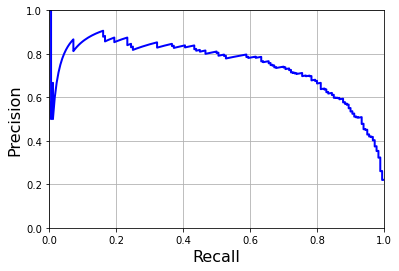

In [35]:
# Ejercicio
svc_poly = SVC(kernel='poly', degree=3, C=1)

y_train_pred_poly = cross_val_predict(svc_poly, X_train1_s, y_train_5, cv=3, method="decision_function", n_jobs = num_cores - 1)

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_train_pred_poly)

plot_precision_vs_recall(precisions, recalls)

auc(recalls, precisions)

# Curva ROC
___

La curva ROC es otra medida muy utilizada en clasificadores binarios. Representa el __recall__ (también llamado true positive rate, TPR) __frente al false positive rate (FPR)__. Es decir, en el eje vertical se representa el recall, de entre los datos positivos, aquellos clasificados correctamente, mientras que en el eje horizontal se representa el FPR, de entre los datos que son negativos, el porcentaje clasificado incorrectamente como positivo, mientras que  Igual que antes, __aquí también hay un trade-off__. Cuanto más alto es el recall, más alta es la tasa de falsos positivos. Para representar la curva ROC gráficamente usamos la función `roc_curve`:

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [37]:
def plot_roc_curve(fpr, tpr):
    """
    fpr: False positive rate (recall)
    tpr: True positive rate (1 - especificidad)
    Representación de la curva ROC
    """
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')                        # Linea diagonal
    plt.axis([0, 1, 0, 1])                                 # Ejes
    plt.xlabel('False Positive Rate', fontsize=16)         # Etiqueta eje x
    plt.ylabel('True Positive Rate (Recall)', fontsize=16) # Etiqueta eje y
    plt.grid(True)                                         # Mallado

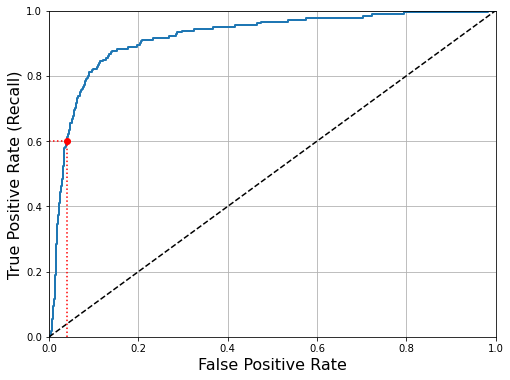

In [38]:
plt.figure(figsize=(8, 6))

plot_roc_curve(fpr, tpr)

fpr_60 = fpr[np.argmax(tpr >= recall_60_precision)]                        # Buscar con qué FPR se tiene el mismo recall que en el trade off anterior
plt.plot([fpr_60, fpr_60], [0., recall_60_precision], "r:")                # Marcar el FPR con linea roja vertical
plt.plot([0.0, fpr_60], [recall_60_precision, recall_60_precision], "r:")  # Marcar TPR con linea roja horizontal
plt.plot([fpr_60], [recall_60_precision], "ro")                            # Marcar punto

Un buen clasificador será el que consiga un buen recall pero no muchos falsos positivos, es decir, que se mantenga en la esquina izquierda. También es interesante medir el area bajo la curva roc, ya que cuanto más cerca esté el clasificador de la esquina superior izquierda, más próxima a 1 estará el area bajo la curva.

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9183241758241759

### <font color='D12828'> Ejercicio: </font>
1. Obtén la gráfica de la curva ROC para la SVM polinómica entrenada antes, y el valor del area bajo su curva.

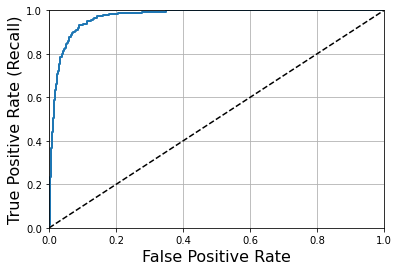

In [42]:
# Ejercicio

fpr, tpr, threshold = roc_curve(y_train_5, y_train_pred_poly)

plot_roc_curve(fpr, tpr)

In [43]:
roc_auc_score(y_train_5, y_train_pred_poly)

0.9714133089133089

Como regla general, si el conjunto de datos no está bien balanceado (es decir, si hay pocos datos de una categoría y muchos de otra, como es nuestro caso) es interesante mirar a la curva precision / recall. Si el conjunto de datos está bien balanceado, con mirar la curva ROC suele ser suficiente.

# Optimización de hiperparámetros
___

Ha habido un tema por el que hemos pasado de puntillas hasta ahora: hemos visto que las distintas SVM's (y en general, los distintos algoritmos de machine learning) tienen una serie de hiperparámetros que podemos modificar y que afectan directamente a la calidad de las predicciones. Por ejemplo:

* En la SVM lineal tenemos el coste,
* En la SVM polinómica tenemos el coste, el grado y coef0
* En la SVM RBF tenemos el coste, y gamma

¿Cómo podemos seleccionar los valores de estos hiperparámetros? Hay dos estrategias básicas a la hora de optimizar el valor de estos parámetros: __grid search__ y __random search__

## Grid search

![image.png](plots/grid_search.png)

La optimización de hiperparámetros con grid search se basa en __definir un mallado de valores__ para los hiperparámetros y __probar todas las posibles combinaciones__ usando validación cruzada. Después, seleccionar los valores de los parámetros que han dado mejores resultados. Este proceso está implementado en la función `GridSearchCV` de sklearn. Cuando no se sabe mucho de los parámetros, lo habitual es definir un mallado en escala logarítmica (potencias de 10). Usemos esta función para buscar los parámetros óptimos de una red RBF:

In [44]:
from sklearn.model_selection import GridSearchCV

svm_rbf = SVC(kernel = 'rbf')

param_grid = [
    {'C':[1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
]

grid_search = GridSearchCV(svm_rbf, param_grid, cv=3,
                           scoring='accuracy',
                           n_jobs=num_cores - 1)

grid_search.fit(X_train1_s, y_train_5)

final_model = grid_search.best_estimator_

In [45]:
final_model

SVC(C=10, gamma=0.001)

Por defecto, cuando la función de `GridSearchCV` encuentra la mejor combinación de parámetros, vuelve a entrenar un modelo con esos valores usando todo el conjunto de train, de forma que el modelo ya esté listo para ser usado. Ese modelo se almacena en `best_estimator_`.  Ahora podemos evaluar nuestro modelo en la parte de test y ver qué tal son los resultados. En primer lugar, __estandarizamos el conjunto de test usando los valores del training set__, y después obtenemos las predicciones.

In [46]:
X_test_s = scaler.transform(X_test)

final_predictions = final_model.predict(X_test_s)

print(confusion_matrix(y_test_5, final_predictions))

print(f'Tasa de aciertos: {accuracy_score(y_test_5, final_predictions)}')
print(f'Recall: {recall_score(y_test_5, final_predictions)}')
print(f'Precision: {precision_score(y_test_5, final_predictions)}')

[[12674    64]
 [  236  1026]]
Tasa de aciertos: 0.9785714285714285
Recall: 0.8129952456418383
Precision: 0.9412844036697248


## Random search

![image.png](plots/random_search.png)

La optimización de hiperparámetros con random search funciona de forma similar, pero en vez de definir un mallado de posibles valores y probar todas las combinaciones, __se evaluan una serie de combinaciones al azar, eligiendo valores aleatorios (dentro de un rango) para los hiperparámetros__. Cuando el número de combinaciones posibles es relativamente pequeño, grid search proporciona muy buenos resultados, sin embargo, cuando el espacio de posibles valores de los hiperparámetros es muy grande, hay estudios que muestran que random search puede ofrecer mejores resultados ya que al moverse al azar, prueba una gran variedad de combinaciones posibles.

Esto está también implementado en sklearn, en la función `RandomizedSearchCV`. Utilicemos esta función para optimizar una SVM polinómica. En primer lugar, definimos el espacio de valores de los hiperparámetros. Podemos (como antes) pasar valores de los parámetros como listas, o también podemos pasar distribuciones estadísticas. 
* Asignamos al coste una distribución log-uniforme (uniforme en la escala logarítmica)
* Asignamos al grado del polinomio una distribución uniforme de números enteros,
* Asignamos al coef0 una distribución normal.

Por último, indicamos el número de iteraciones (número de combinaciones a probar)

In [47]:
from scipy.stats import loguniform, randint, norm
from sklearn.model_selection import RandomizedSearchCV

param = {
    'C': loguniform(1e-3, 1e3), 
    'degree': randint(1,6),
    'coef0': norm()
}

In [48]:
svm_poly = SVC(kernel = 'poly')
rnd_search = RandomizedSearchCV(svm_poly, 
                                param_distributions = param, 
                                n_iter=35, cv=3,
                               n_jobs = num_cores - 1)

rnd_search.fit(X_train1_s, y_train_5)

final_model_rdn = rnd_search.best_estimator_

In [50]:
final_model_rdn

SVC(C=36.25116711055814, coef0=0.15897075329234808, degree=2, kernel='poly')

In [49]:
final_predictions_rdn = final_model_rdn.predict(X_test_s)

print(confusion_matrix(y_test_5, final_predictions_rdn))

print(f'Tasa de aciertos: {accuracy_score(y_test_5, final_predictions_rdn)}')
print(f'Recall: {recall_score(y_test_5, final_predictions_rdn)}')
print(f'Precision: {precision_score(y_test_5, final_predictions_rdn)}')

[[12664    74]
 [  212  1050]]
Tasa de aciertos: 0.9795714285714285
Recall: 0.8320126782884311
Precision: 0.9341637010676157


# Problemas multiclase
___
Hasta ahora hemos trabajado con un problema binario: distinguir las imagenes de cincos, de otras imágenes que no eran cincos. Pero en la base de datos teníamos imágenes de dígitos de 0 a 9, es decir, en realidad teníamos 10 categorías. Esto es lo que se conoce como un problema multiclase. Hay algunos algoritmos que permiten trabajar directamente con problemas multiclase, pero otros, como las SVM, solo sirven para problemas binarios. Cuando se quiere usar una SVM en un problema binario, sklearn lo detectará automáticamente y utilizará la estrategia conocida como  __One versus One__ (OvO), en la que entrenará un clasificador SVM binario para cada par de dígitos. Si hay $k$ clases, se entrenarán $k\times(k-1)/2$ SVMs, pero cada una tendrá un conjunto de entrenamiento reducido (el referente solo a las dos categorías que quiera clasificar).

Para entrenar una SVM multiclase, simplemente tenemos que indicar que nuestro vector respuesta es `y_train1` y no `y_train1_5`. Y con esto construiremos un algoritmo capaz de recibir como input la imagen de un dígito escrito a mano y de clasificar a qué número corresponde.

### <font color='D12828'> Ejercicio: </font>
Entrena una SVM para que clasifique las imágenes de los distintos dígitos (y no solo cinco vs no cinco). Busca el valor óptimo de los hiperparámetros.

__Aviso__: Recomiendo utilizar el conjunto de datos reducido (con 2000 observaciones) y probar un conjunto de hiperparámetros  relativamente pequeño (en torno a 30 o 40) para mantener un tiempo computacional reducido (unos pocos minutos). 


In [ ]:
# Ejercicio


# Final
___
Con esto termina nuestro análisis del conjunto de datos de MNIST.

![image.png](plots/fin_svm_2.png)